In [1]:
from tools import *
from data import *
from ensemble import *
import json

In [17]:
def show_top_weights(results):
    top_5_accuracies = sorted(results, key=lambda x: x['accuracy'], reverse=True)[:5]
    bottom_5_loglosses = sorted(results, key=lambda x: x['log_loss'])[:5]

    print("Top 5 Accuracies:")
    for i, result in enumerate(top_5_accuracies, 1):
        print(f"{i}. Weights: {[round(float(w), 2) for w in result['weights']]} | Accuracy: {result['accuracy']:.3f} | Log Loss: {result['log_loss']:.3f}")

    print("\nBottom 5 Log Losses:")
    for i, result in enumerate(bottom_5_loglosses, 1):
        print(f"{i}. Weights: {[round(float(w), 2) for w in result['weights']]} | Accuracy: {result['accuracy']:.3f} | Log Loss: {result['log_loss']:.3f}")

In [ ]:
with open('model_xgb_params.json', 'r') as file:
    xgb_params = json.load(file)

results, best_result = train_ensemble(X_train, y_train, mean_type='arithmetic', xgb_params=xgb_params)
show_top_weights(results)

In [18]:
results, best_result = train_ensemble(X_train, y_train, mean_type='geometric', xgb_params=xgb_params)
show_top_weights(results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 5 Accuracies:
1. Weights: [0.25, 0.0, 0.75] | Accuracy: 0.707 | Log Loss: 0.689
2. Weights: [0.6, 0.1, 0.3] | Accuracy: 0.707 | Log Loss: 0.687
3. Weights: [0.8, 0.0, 0.2] | Accuracy: 0.707 | Log Loss: 0.688
4. Weights: [0.25, 0.35, 0.4] | Accuracy: 0.706 | Log Loss: 0.697
5. Weights: [0.65, 0.1, 0.25] | Accuracy: 0.706 | Log Loss: 0.688

Bottom 5 Log Losses:
1. Weights: [0.55, 0.0, 0.45] | Accuracy: 0.702 | Log Loss: 0.684
2. Weights: [0.5, 0.0, 0.5] | Accuracy: 0.702 | Log Loss: 0.684
3. Weights: [0.6, 0.0, 0.4] | Accuracy: 0.705 | Log Loss: 0.684
4. Weights: [0.45, 0.0, 0.55] | Accuracy: 0.700 | Log Loss: 0.685
5. Weights: [0.5, 0.05, 0.45] | Accuracy: 0.702 | Log Loss: 0.685


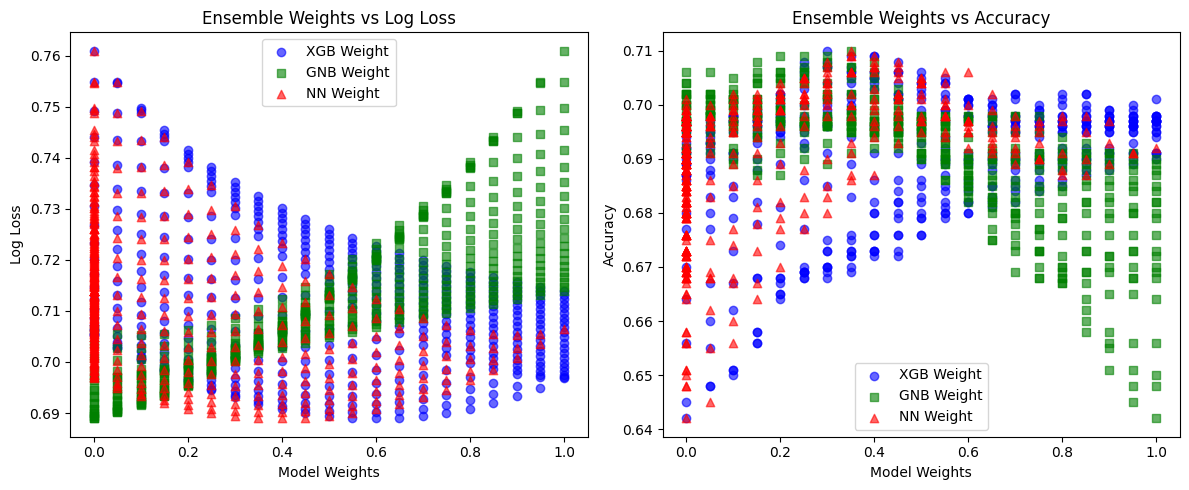

In [3]:
# Extract weights and performance metrics
weights_xgb = [res['weights'][0] for res in results]
weights_gnb = [res['weights'][1] for res in results]
weights_nn = [res['weights'][2] for res in results]
log_losses = [res['log_loss'] for res in results]
accuracies = [res['accuracy'] for res in results]

# Plot Log Loss vs. Model Weights
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(weights_xgb, log_losses, label='XGB Weight', alpha=0.6, marker='o', color='blue')
plt.scatter(weights_gnb, log_losses, label='GNB Weight', alpha=0.6, marker='s', color='green')
plt.scatter(weights_nn, log_losses, label='NN Weight', alpha=0.6, marker='^', color='red')
plt.xlabel("Model Weights")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Ensemble Weights vs Log Loss")

# Plot Accuracy vs. Model Weights
plt.subplot(1, 2, 2)
plt.scatter(weights_xgb, accuracies, label='XGB Weight', alpha=0.6, marker='o', color='blue')
plt.scatter(weights_gnb, accuracies, label='GNB Weight', alpha=0.6, marker='s', color='green')
plt.scatter(weights_nn, accuracies, label='NN Weight', alpha=0.6, marker='^', color='red')
plt.xlabel("Model Weights")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Ensemble Weights vs Accuracy")

plt.tight_layout()
plt.show()


In [4]:
best_result

{'weights': (np.float64(0.6000000000000001),
  np.float64(0.0),
  np.float64(0.3999999999999999)),
 'accuracy': 0.7,
 'log_loss': 0.6889534333760069}

In [6]:
max(results, key=lambda x: x['accuracy'])

{'weights': (np.float64(0.30000000000000004),
  np.float64(0.35000000000000003),
  np.float64(0.34999999999999987)),
 'accuracy': 0.71,
 'log_loss': 0.7033379528649314}

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract weights and performance metrics
weights_xgb = [res['weights'][0] for res in results]
weights_gnb = [res['weights'][1] for res in results]
log_losses = [res['log_loss'] for res in results]
accuracies = [res['accuracy'] for res in results]

# Create grid for plotting
weight_options = np.linspace(0, 1, 21)
X, Y = np.meshgrid(weight_options, weight_options)
Z_accuracy = np.full(X.shape, np.nan)
Z_log_loss = np.full(X.shape, np.nan)

# Fill the grid with accuracy and log loss values
for i, w_xgb in enumerate(weight_options):
    for j, w_gnb in enumerate(weight_options):
        if w_xgb + w_gnb <= 1:
            w_nn = 1 - (w_xgb + w_gnb)
            idx = next(k for k, res in enumerate(results) if np.isclose(res['weights'][0], w_xgb) and np.isclose(res['weights'][1], w_gnb))
            Z_accuracy[i, j] = accuracies[idx]
            Z_log_loss[i, j] = log_losses[idx]

# Plotting accuracy
fig = plt.figure(figsize=(14, 7))

# Plot Accuracy surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_accuracy, cmap='viridis')
ax1.set_xlabel('XGBoost Weight')
ax1.set_ylabel('GNB Weight')
ax1.set_zlabel('Accuracy')
ax1.set_title('Accuracy vs Model Weights')

# Plot Log Loss surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_log_loss, cmap='plasma')
ax2.set_xlabel('XGBoost Weight')
ax2.set_ylabel('GNB Weight')
ax2.set_zlabel('Log Loss')
ax2.set_title('Log Loss vs Model Weights')

plt.tight_layout()
plt.show()
